- 평점이 낮은 회차와 웹툰분량간의 상관관계 파악
    - 추가적으로 평점이 낮은 회차와 해당기간의 뉴스 기사 개수 관계 파악
- 연도별 웹툰 장르의 변화추이
- 현재 웹툰 인기순 정렬 이유 분석 -> 좀 더 구체적으로?
- 장르별 평점순위

- 추가해볼 데이터
    - 웹툰 회차별 상세페이지의 댓글 수
    - 하트 수 다시 한 번 해보기

In [158]:
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

f_path = '/Library/Fonts/NanumBarunGothic.otf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

---

### 연습

In [1]:
import urllib.parse

base_url = 'https://comic.naver.com/'
url = 'https://comic.naver.com/webtoon/weekday.nhn'

response = requests.get(url)
dom = BeautifulSoup(response.content, 'html.parser')
print(url)

https://comic.naver.com/webtoon/weekday.nhn


In [2]:
day = 1
condition = '#content > div.list_area.daily_all > div:nth-of-type({}) > div > ul > li'.format(day)
elements = dom.select(condition)
    
title =  [element.find_all('a', 'title')[0].text for element in elements]
links = [urllib.parse.urljoin(base=base_url, url=element.select_one('a').get('href'), allow_fragments=True) for element in elements]
title_ids = [link.split("Id=")[1].split('&')[0] for link in links]
print(links[1])
len(links), len(title), len(title_ids)

https://comic.naver.com/webtoon/list.nhn?titleId=648419&weekday=mon


In [76]:
# 이미지 개수 크롤링
number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
print(number)

url = 'https://comic.naver.com/webtoon/detail.nhn?titleId={}&no={}&weekday=mon'.format(title_ids[0], number)
response = requests.get(url)
dom = BeautifulSoup(response.content, 'html.parser')
elements = dom.select('#comic_view_area > div.wt_viewer > img')
len(elements)

85

# 연재중인 웹툰 인기순 크롤링
- 2021.03.31 기준
    - 총 392개의 웹툰 데이터 수집
    - columns
        - day : 요일별
        - rank : 순위
        - title : 웹툰 제목
        - link : 웹툰 링크 -> 향후 삭제 예정
        - title_id : 웹툰 고유번호 -> 향후 삭제 예정
        - star : 웹툰 평균 평점
        - img : 웹툰 평균 분량

In [140]:
# 특정 웹툰의 모든 회차의 평점 데이터를 리턴해주는 함수 (callback function : get_page_scores)
def get_all_scores(link):
    
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')
    
    number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
    page = int(np.ceil(number/10))
    page_ls = []
    while page:
        result = get_page_scores(link, page)
        page_ls.extend(result)
        page -= 1
    
    return page_ls


# 특정 웹툰의 모든 회차의 평점 데이터의 평균을 리턴해주는 함수 (callback function : get_page_scores)
def get_all_scores_mean(link):
    
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')
    
    number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
    page = int(np.ceil(number/10))
    page_ls = []
    while page:
        result = get_page_scores(link, page)
        page_ls.extend(result)
        page -= 1
    
    return np.mean(page_ls).round(2)


# 특정 웹툰의 해당 페이지의 평점 데이터를 리턴해주는 함수
def get_page_scores(link, page):
    import re
    
    url = (link + '&page={}').format(page)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, 'html.parser')
    elements = dom.find_all('div', 'rating_type')
    
    ls = []
    for element in elements:
        score = float(re.search('\d.\d+', element.text).group())
        ls.append(score)
        
    return ls


# 특정 웹툰의 장르를 리턴하는 함수
def get_genre(link):
    
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')
    return dom.find('span', 'genre').text.replace(',','')

# 요일별 웹툰 데이터들의 데이터프레임을 리턴해주는 함수
def make_week_webtoon(day, dom):
    print(day)
    condition = '#content > div.list_area.daily_all > div:nth-of-type({}) > div > ul > li'.format(day)
    elements = dom.select(condition)
    
    title =  [element.find_all('a', 'title')[0].text for element in elements]
    links = [urllib.parse.urljoin(base=base_url, url=element.select_one('a').get('href'), allow_fragments=True) for element in elements]
    title_ids = [link.split("Id=")[1].split('&')[0] for link in links]
    
    webtoon_df = pd.DataFrame({"title": title, "title_id": title_ids, "link": links})
    time.sleep(1)
    webtoon_df['genre'] = webtoon_df['link'].apply(get_genre)
    time.sleep(1)
    webtoon_df['star'] = webtoon_df["link"].apply(get_all_scores_mean)
    
    return webtoon_df

In [141]:
import urllib.parse

base_url = 'https://comic.naver.com/'
url = 'https://comic.naver.com/webtoon/weekday.nhn'

response = requests.get(url)
dom = BeautifulSoup(response.content, 'html.parser')


day_of_week = {1:"Mon", 2:"Tues", 3:"Wed", 4:"Thur", 5:"Fri", 6:"Sat", 7:"Sun"}
weekly_dfs = []
for day in range(1, 8):
    week_webtoon_df = make_week_webtoon(day, dom)
    week_webtoon_df["day"] = day_of_week[day]
    weekly_dfs.append(week_webtoon_df)

1
2
3
4
5
6
7


In [148]:
df = pd.concat(weekly_dfs, axis=0)
print(len(df))
df.tail()

392


,title,title_id,link,genre,star,day
387,데이즈,752462,https://comic.naver.com/webtoon/list.nhn?title...,스토리 스릴러,8.02,Sun
388,죽여주는 탐정님,744313,https://comic.naver.com/webtoon/list.nhn?title...,스토리 스릴러,9.87,Sun
389,스트러글,758674,https://comic.naver.com/webtoon/list.nhn?title...,스토리 액션,9.29,Sun
390,샤인 스타,758665,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.92,Sun
391,호시탐탐,758145,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.76,Sun


### 각 웹툰의 연재분량
- 각 웹툰의 모든 회차의 이미지 수의 평균을 냄

In [ ]:
def get_all_imgs_mean(link):
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')

    title_id = link.split("Id=")[1].split('&')[0]
    number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
    print(number)
    number_ls = []
    while number:
        url = 'https://comic.naver.com/webtoon/detail.nhn?titleId={}&no={}&weekday=mon'.format(title_id, number)
        response = requests.get(url)
        dom = BeautifulSoup(response.content, 'html.parser')
        elements = dom.select('#comic_view_area > div.wt_viewer > img')
        number_ls.append(len(elements))
        number -= 1
        
    return np.mean(number_ls).round(2)

In [186]:
df['img'] = df['link'].apply(get_all_imgs_mean)
df

22
289
356


KeyboardInterrupt: 

### 객체 저장

In [149]:
import pickle

with open('data/weekly_dataframe.pkl', 'wb') as f:
    pickle.dump(df, f)

In [184]:
with open('data/weekly_dataframe.pkl', 'rb') as f:
    load_datas = pickle.load(f)
    
len(load_datas)
load_datas.tail(2)

,title,title_id,link,genre,star,day
390,샤인 스타,758665,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.92,Sun
391,호시탐탐,758145,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.76,Sun


---

---

# 연재중인 웹툰들의 회차별 평점들의 데이터
- 2021.03.31 기준 수집
- weekly_scores.pkl
```
[
    {'월요일 웹툰[0]' : [각 회차별 평점], ... , '월요일 웹툰[-1]' : [각 회차별 평점]},
                                         .
                                         .
                                         .
    {'일요일 웹툰' : [각 회차별 평점], ... , '일요일 웹툰[-1]' : [각 회차별 평점]}
]
```

In [111]:
def get_all_scores(link):
    
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')
    
    number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
    page = int(np.ceil(number/10))
    page_ls = []
    while page:
        result = get_page_scores(link, page)
        page_ls.extend(result)
        page -= 1
    
    return page_ls


def get_page_scores(link, page):
    import re
    
    url = (link + '&page={}').format(page)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, 'html.parser')
    elements = dom.find_all('div', 'rating_type')
    
    ls = []
    for element in elements:
        score = float(re.search('\d.\d+', element.text).group())
        ls.append(score)
        
    return ls

In [113]:
import urllib.parse


base_url = 'https://comic.naver.com/'
url = 'https://comic.naver.com/webtoon/weekday.nhn'

response = requests.get(url)
dom = BeautifulSoup(response.content, 'html.parser')

dfs = []
for day in range(1, 8):
    print(day)
    condition = '#content > div.list_area.daily_all > div:nth-of-type({}) > div > ul > li'.format(day)
    elements = dom.select(condition)
        
    title =  [element.find_all('a', 'title')[0].text for element in elements]
    links = [urllib.parse.urljoin(base=base_url, url=element.select_one('a').get('href'), allow_fragments=True) for element in elements]
    
    weekly_all_scores = {}
    for idx, link in enumerate(links):
        result = get_all_scores(link)
        weekly_all_scores[title[idx]] = result
    print('Get {}day all scores'.format(day))
    dfs.append(weekly_all_scores)

1
Get 1day all scores
2
Get 2day all scores
3
Get 3day all scores
4
Get 4day all scores
5
Get 5day all scores
6
Get 6day all scores
7
Get 7day all scores


In [114]:
len(dfs)

7

In [127]:
for data in dfs:
    for idx, key in enumerate(data.keys()):
        print('{}, {}'.format(key, len(data[key])))
    print()
    print()

참교육, 22
뷰티풀 군바리, 289
윈드브레이커, 356
소녀의 세계, 265
장씨세가 호위무사, 98
파이게임, 39
만렙돌파, 19
유일무이 로맨스, 132
브랜든, 4
칼가는 소녀, 91
앵무살수, 59
요리GO, 128
착한건 돈이된다, 7
잔불의 기사, 4
야생천사 보호구역, 5
싸이코 리벤지, 31
히어로메이커, 763
오늘의 순정망화, 313
수영만화일기, 3
결혼생활 그림일기, 57
평범한 8반, 343
리턴 투 플레이어, 32
아는 여자애, 65
사장님을 잠금해제, 52
백수세끼, 77
바이러스X, 24
선배, 그 립스틱 바르지 마요, 13
마지막 지수, 9
순정말고 순종, 16
살아간다, 1
그림자 신부, 9
꿈의 기업, 226
황제와의 하룻밤, 5
서브 콤플렉스, 45
침범, 34
왕따협상, 28
피플, 157
두근두근 네가 좋아서, 46
와이키키 뱀파이어, 49
오로지 오로라, 9
라서드, 15
도플갱어의 게임, 58
개밥 먹는 남자, 16
정보전사 202, 79
트리거, 11
이탄국의 자청비, 18
이중첩자, 26
뱀파이어의 꽃, 102
원하는 건 너 하나, 36
백호랑, 48
여기 악마가 있어, 79
드로잉 레시피, 37
인간의 온도, 69
하슬라, 90
헬로맨스, 32
보살님이 캐리해!, 22


여신강림, 155
엽총소년, 6
한림체육관, 45
바른연애 길잡이, 143
하루만 네가 되고 싶어, 66
랜덤채팅의 그녀!, 175
사신소년, 90
헬58, 121
신도림, 212
호랑이 들어와요, 24
삼국지톡, 287
위아더좀비, 8
원주민 공포만화, 192
중증외상센터 : 골든 아워, 65
달콤살벌한 부부, 30
태시트, 7
집이 없어, 110
악인, 10
오피스 누나 이야기, 28
빌런투킬, 8
윌유메리미, 714
하우스키퍼, 82
오늘의 순정망화, 313
아이즈, 4
아이레, 25
견우와 선녀, 61
용왕님의 셰프가 되었습니다, 58
올가미, 78
성인초딩, 26
플레이, 플리, 29
3cm 헌터, 68
빅맨, 28
제로게임, 2

In [128]:
import pickle

with open('data/weekly_scores.pkl', 'wb') as f:
    pickle.dump(dfs, f)

### 월요일 연재 웹툰들의 회차별 평점 데이터프레임

In [133]:
datas = []
for k, v in dfs[0].items():
    df = pd.DataFrame({k:v})
    datas.append(df)
    
pd.concat(datas, axis=1)

,참교육,뷰티풀 군바리,윈드브레이커,소녀의 세계,장씨세가 호위무사,파이게임,만렙돌파,유일무이 로맨스,브랜든,칼가는 소녀,...,이중첩자,뱀파이어의 꽃,원하는 건 너 하나,백호랑,여기 악마가 있어,드로잉 레시피,인간의 온도,하슬라,헬로맨스,보살님이 캐리해!
0,9.70,9.79,9.96,9.97,9.98,9.94,9.52,9.96,9.89,9.92,...,9.90,9.81,8.89,9.96,9.96,9.97,9.92,9.81,9.69,9.87
1,9.83,9.70,9.96,9.98,9.98,9.97,9.25,9.95,9.85,9.98,...,9.93,9.77,8.27,9.97,9.95,9.97,9.90,9.97,9.72,9.65
2,9.90,9.66,9.96,9.96,9.97,9.96,8.88,9.98,9.84,9.97,...,9.96,9.85,8.38,9.96,9.96,9.97,9.91,9.96,9.90,9.91
3,9.78,9.77,9.94,9.95,9.96,9.95,8.58,9.98,9.62,9.99,...,9.95,9.88,8.52,9.96,9.95,9.97,9.96,9.97,9.81,9.95
4,9.68,9.75,9.94,9.94,9.97,9.96,7.70,9.98,NaN,9.98,...,9.95,9.83,8.48,9.95,9.94,9.97,9.96,9.96,9.86,9.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 연재중인 웹툰들의 회차별 분량 데이터

In [1]:
def get_all_imgs(link):
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')

    title_id = link.split("Id=")[1].split('&')[0]
    number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
    print(number)
    number_ls = []
    while number:
        url = 'https://comic.naver.com/webtoon/detail.nhn?titleId={}&no={}&weekday=mon'.format(title_id, number)
        response = requests.get(url)
        dom = BeautifulSoup(response.content, 'html.parser')
        elements = dom.select('#comic_view_area > div.wt_viewer > img')
        number_ls.append(len(elements))
        number -= 1
        
    return number_ls

In [ ]:
import urllib.parse


base_url = 'https://comic.naver.com/'
url = 'https://comic.naver.com/webtoon/weekday.nhn'

response = requests.get(url)
dom = BeautifulSoup(response.content, 'html.parser')

dfs = []
for day in range(1, 8):
    print(day)
    condition = '#content > div.list_area.daily_all > div:nth-of-type({}) > div > ul > li'.format(day)
    elements = dom.select(condition)
    
    title =  [element.find_all('a', 'title')[0].text for element in elements]
    links = [urllib.parse.urljoin(base=base_url, url=element.select_one('a').get('href'), allow_fragments=True) for element in elements]
    
    weekly_all_imgs = {}
    for idx, link in enumerate(links):
        result = get_all_imgs(link)
        weekly_all_imgs[title[idx]] = result
    print('Get {}day all scores'.format(day))
    dfs.append(weekly_all_imgs)

### 월요일 연재 웹툰들의 회차별 이미지 수 데이터프레임

In [ ]:
datas = []
for k, v in dfs[0].items():
    df = pd.DataFrame({k:v})
    datas.append(df)
    
pd.concat(datas, axis=1)

In [ ]:
with open('data/weekly_imgs.pkl', 'wb') as f:
    pickle.dump(dfs, f)

---

---

# Test Visualization

In [214]:
df['count'] = 1
df.tail(2)
result_df = df.groupby('genre').agg('sum').sort_values('count', ascending=False)
result_df = result_df[['star', 'count']].reset_index()

In [217]:
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

f_path = '/Library/Fonts/NanumBarunGothic.otf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

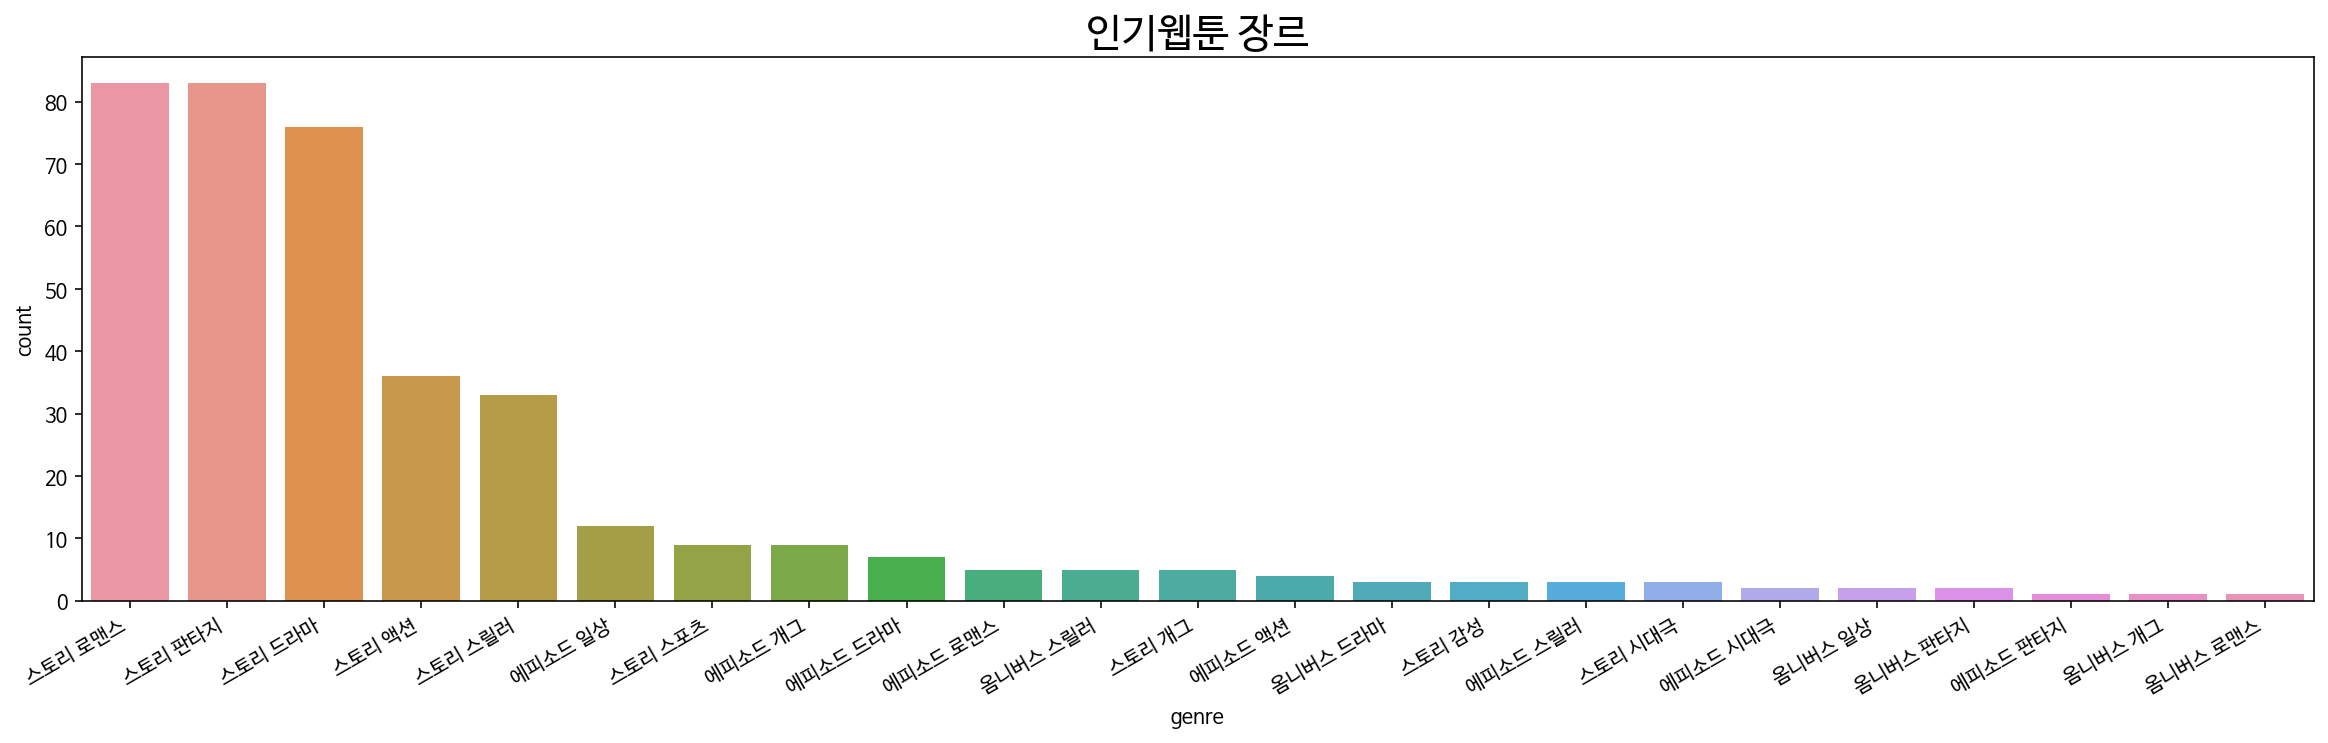

In [223]:
plt.figure(figsize=(20, 5))
sns.barplot(data=result_df, x=result_df["genre"], y=result_df["count"])
plt.xticks(rotation=30, ha="right");
plt.title('인기웹툰 장르', fontsize=20);

In [53]:
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

f_path = '/Library/Fonts/NanumBarunGothic.otf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

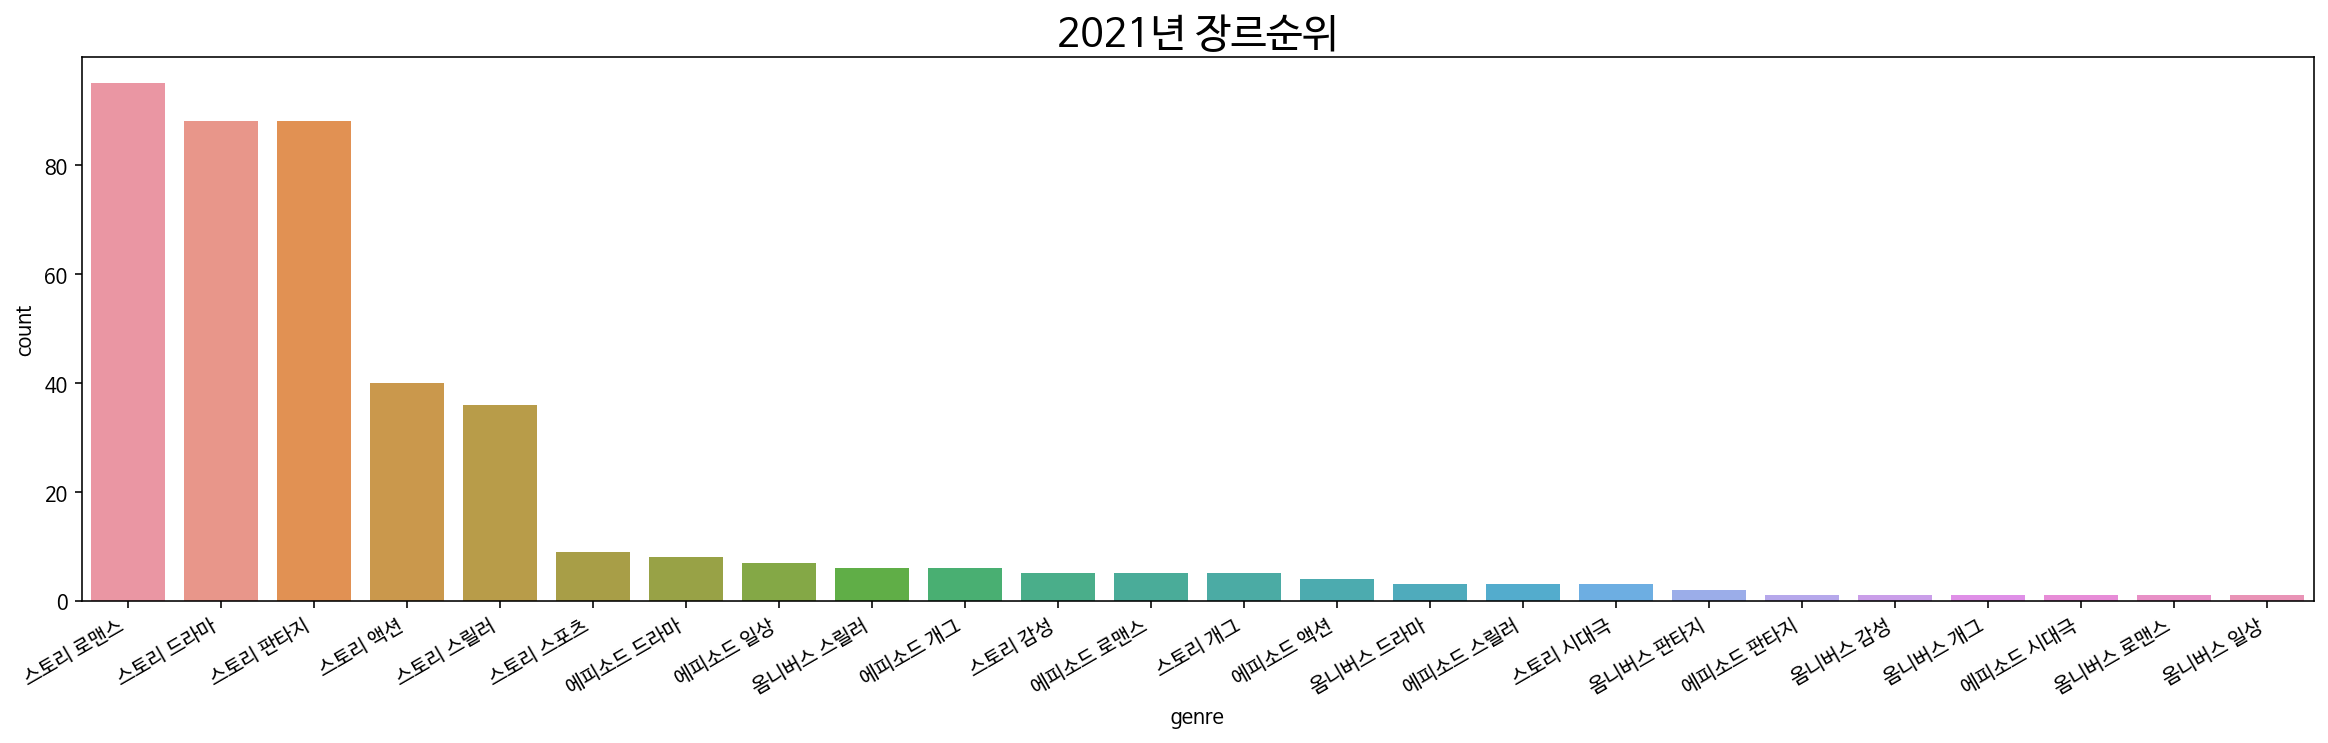

In [56]:
df['count'] = 1
df.tail(2)
result_df = df.groupby('genre').agg('sum').sort_values('count', ascending=False)
result_df = result_df[['star', 'count']].reset_index()

plt.figure(figsize=(20, 5))
sns.barplot(data=result_df, x=result_df["genre"], y=result_df["count"])
plt.xticks(rotation=30, ha="right");
plt.title('2021년 장르순위', fontsize=20);

# 2005 ~ 2021 연도별 웹툰 크롤링

In [59]:
# 연도별 웹툰데이터(title, link, genre, mean(star))를 갖고와 df화 해주는 함수
def make_year_webtoon(year):
    base_url = 'https://comic.naver.com/'
    url = 'https://comic.naver.com/webtoon/period.nhn?period={}'.format(year)
    
    response = requests.get(url)
    dom = BeautifulSoup(response.content, 'html.parser')
    elements = dom.select('#content > div.list_area.daily_img > ul > li')
    
    title = [element.select_one('dl > dt > a').text for element in elements]
    links = [urllib.parse.urljoin(base=base_url, url=element.select_one('dl > dt > a').get('href'), allow_fragments=True)\
         for element in elements]
    
    df = pd.DataFrame({'title':title, 'link':links})
    df['genre'] = df['link'].apply(get_genre)
    df['star'] = df['link'].apply(get_all_scores_mean)
    
    return df

In [60]:
datas_year = []
for year in list(range(2005, 2022)):
    print(year)
    year_webtoon_df = make_year_webtoon(year)
    year_webtoon_df['year'] = year
    datas_year.append(year_webtoon_df)
    
datas_year

2005
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
1
2
2006
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
1
2
3
4
5
6
1
2
1
2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
1
2
3
4
5
6
1
2
3
4
5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
1
2
3
4
5
6
7
2007
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
1
2
3
4
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
1
2
3
4
5
6
1
2

KeyboardInterrupt: 

In [ ]:
all_year_dfs = pd.concat(dates_year, axis=0)
# get_all_imgs_mean 함수를 사용해 웹툰 분량 데이터 추가